In [2]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
%matplotlib inline

In [1]:
# Load the Dataset
tensor_transform = transforms.Compose([
    transforms.ToTensor()
])

dataset = datasets.MNIST(root="./data", train=True, download=True, transform=tensor_transform)
loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=32, shuffle=True)

# Collect Parameters
learning_rate = 1e-3
weight_decay = 1e-8

epochs = 20

input_size = 28


NameError: name 'transforms' is not defined

Running on the GPU


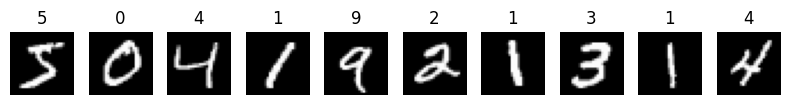

In [ ]:
fig, axes = plt.subplots(1, 10, figsize=(8, 2))
for i in range(10):
    axes[i%10].imshow(loader.dataset.data[i], cmap='gray')
    axes[i%10].axis('off')
    axes[i%10].set_title(f"{loader.dataset.targets[i]}")
    
plt.tight_layout()


if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print('Running on the GPU')
else:
    device = torch.device('cpu')
    print('Running on the CPU')

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.decoder = torch.nn.Sequential(
            nn.ConvTranspose2d(64, 32, 
                               kernel_size=3, 
                               stride=2, 
                               padding=1, 
                               output_padding=1),
            nn.ReLU(),
            
            nn.ConvTranspose2d(32, 1, 
                               kernel_size=3, 
                               stride=2, 
                               padding=1, 
                               output_padding=1),
            nn.Sigmoid()
        )


    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
model = AutoEncoder()
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [ ]:
def train():
    outputs = []
    losses = []

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(epochs):
        with tqdm(loader, desc=f"Epoch {epoch+1}/{epochs}") as t:
            for images, _ in t:
                images = images.view(images.size(0), -1, input_size, input_size).to(device)
                def add_noise(image, noise_factor=0.3):
                    noise = torch.randn_like(image) * noise_factor
                    noisy_image = image + noise
                    return torch.clamp(noisy_image, 0., 1.)  

                noisy_images = add_noise(images)

                reconstructed = model(noisy_images)
                loss = loss_function(reconstructed, images)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                losses.append(loss.item())
                
                t.set_postfix(loss=f"{loss.item():.6f}")

        outputs.append((epoch, images, reconstructed))
    
def plot_loss(losses):
    plt.style.use('fivethirtyeight')
    plt.figure(figsize=(8, 5))
    plt.plot(losses, label='Loss')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

#plot_loss(losses)

In [ ]:
def visualize_latent_and_train_space(model, images, labels, input_size=28):
    device = next(model.parameters()).device
    model.eval()

    # Move data to device
    images = images.to(device)
    labels = labels.cpu().numpy()  # Ensure labels are on CPU for plotting

    with torch.no_grad():
        # Encode images into latent space
        latent_vectors = model.encoder(images.view(images.size(0), 1, input_size, input_size))
        latent_vectors = latent_vectors.view(images.size(0), -1).cpu().numpy()

    # Flatten original images for direct visualization
    train_vectors = images.view(images.size(0), -1).cpu().numpy()

    tsne = TSNE(n_components=2, random_state=42, perplexity=15)
    latent_2d = tsne.fit_transform(latent_vectors)
    train_2d = tsne.fit_transform(train_vectors)

    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    # Original Data Space Visualization
    scatter2 = axs[0].scatter(train_2d[:, 0], train_2d[:, 1], c=labels, cmap='tab10', alpha=0.7)
    axs[0].set_title('Original Data Space (t-SNE)')
    axs[0].set_xlabel('t-SNE Dimension 1')
    axs[0].set_ylabel('t-SNE Dimension 2')
    plt.colorbar(scatter2, ax=axs[1], ticks=range(10), label='Digit Labels')

    # Latent Space Visualization
    scatter1 = axs[1].scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap='tab10', alpha=0.7)
    axs[1].set_title('Latent Space (t-SNE)')
    axs[1].set_xlabel('t-SNE Dimension 1')
    axs[1].set_ylabel('t-SNE Dimension 2')
    plt.colorbar(scatter1, ax=axs[0], ticks=range(10), label='Digit Labels')

    plt.tight_layout()
    plt.show()


# Get a batch of images and labels
#images, labels = next(iter(loader))

# Limit to n_samples
#images, labels = images[:10000], labels[:10000]

#visualize_latent_and_train_space(model, images, labels)


In [ ]:
def visualize_reconstruction(model, loader, input_size=28):
    dataiter = iter(loader)
    images, _ = next(dataiter)
    noisy_images = images[:10].to(device)

    def add_noise(image, noise_factor=0.4):
        noise = torch.randn_like(image) * noise_factor
        noisy_image = image + noise
        return torch.clamp(noisy_image, 0., 1.)  

    noisy_images = add_noise(noisy_images)

    reconstructed = model(noisy_images)

    fig, axes = plt.subplots(nrows=3, ncols=10, figsize=(12, 6))
    for i in range(10):
        axes[0, i].imshow(images[i].cpu().detach().numpy().reshape(input_size, input_size), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(noisy_images[i].cpu().detach().numpy().reshape(input_size, input_size), cmap='gray')
        axes[1, i].axis('off')
        axes[2, i].imshow(reconstructed[i].cpu().detach().numpy().reshape(input_size, input_size), cmap='gray')
        axes[2, i].axis('off')

    plt.show()


# Use it for recommendations

In [3]:
# Load the Dataset
df = pd.read_csv('data/lfm_interactions.csv', sep="\t", index_col=0)
inter_matr = pd.pivot_table(df, values='count', index='user_id', columns='item_id')
inter_matr = inter_matr.fillna(0).to_numpy()
inter_matr = (inter_matr > 0).astype(int)

inter_tensor = torch.FloatTensor(inter_matr)
train_data, test_data = train_test_split(inter_tensor, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)


In [4]:
class RecAutoEncoder(nn.Module):
    def __init__(self, input_size, hidden_size, dropout=0.2):
        super(RecAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(input_size, hidden_size),
            nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size, input_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [5]:
class AutoEncoderRecommender:
    def __init__(self, input_size, hidden_size=128, learning_rate=0.001, epochs=100, batch_size=64, dropout=0.2):
        self.model = RecAutoEncoder(input_size, hidden_size, dropout)
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        self.criterion = nn.MSELoss()
        self.epochs = epochs
        self.batch_size = batch_size
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        
    def train(self, train_data, val_data=None):
        self.model.train()
        n_samples = train_data.shape[0]
        
        train_losses = []
        val_losses = []
        
        for epoch in range(self.epochs):
            indices = torch.randperm(n_samples)
            total_loss = 0
            
            for start_idx in range(0, n_samples, self.batch_size):
                end_idx = min(start_idx + self.batch_size, n_samples)
                batch_indices = indices[start_idx:end_idx]
                
                x = train_data[batch_indices].to(self.device)
                
                self.optimizer.zero_grad()
                outputs = self.model(x)
                
                if hasattr(x, 'is_sparse') and x.is_sparse:
                    mask = x != 0
                    loss = self.criterion(outputs * mask, x * mask)
                else:
                    loss = self.criterion(outputs, x)
                
                loss.backward()
                self.optimizer.step()
                
                total_loss += loss.item() * len(batch_indices)
            
            avg_train_loss = total_loss / n_samples
            train_losses.append(avg_train_loss)
            
            if val_data is not None:
                val_loss = self.evaluate(val_data)
                val_losses.append(val_loss)
                print(f'Epoch [{epoch+1}/{self.epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}')
            else:
                print(f'Epoch [{epoch+1}/{self.epochs}], Train Loss: {avg_train_loss:.4f}')
        
        return train_losses, val_losses
    
    def evaluate(self, data):
        self.model.eval()
        with torch.no_grad():
            data = data.to(self.device)
            outputs = self.model(data)
            
            if hasattr(data, 'is_sparse') and data.is_sparse:
                mask = data != 0
                loss = self.criterion(outputs * mask, data * mask)
            else:
                loss = self.criterion(outputs, data)
                
        return loss.item()
    
    def predict(self, user_data):
        self.model.eval()
        with torch.no_grad():
            user_data = user_data.to(self.device)
            predictions = self.model(user_data)
        return predictions
    
    def recommend_items(self, user_data, user_idx=None, top_k=10, exclude_known=True):
        if user_idx is not None:
            user_vector = user_data[user_idx].unsqueeze(0)
        else:
            user_vector = user_data
            
        predictions = self.predict(user_vector).squeeze().cpu().numpy()
        
        if exclude_known and user_idx is not None:
            known_items = user_data[user_idx].cpu().numpy() > 0
            predictions[known_items] = -float('inf')
        
        top_items = np.argsort(predictions)[::-1][:top_k]
        
        return [(item_idx, predictions[item_idx]) for item_idx in top_items]
    
    def save_model(self, path):
        torch.save(self.model.state_dict(), path)
    
    def load_model(self, path):
        self.model.load_state_dict(torch.load(path, map_location=self.device))

In [6]:
n_items = inter_tensor.shape[1]
hidden_size = 128

recommender = AutoEncoderRecommender(
        input_size=n_items,
        hidden_size=hidden_size,
        learning_rate=0.001,
        epochs=200,
        batch_size=32,
        dropout=0.02
    )
    
train_losses, val_losses = recommender.train(train_data, val_data)

Epoch [1/200], Train Loss: 0.1026, Val Loss: 0.0161
Epoch [2/200], Train Loss: 0.0126, Val Loss: 0.0127
Epoch [3/200], Train Loss: 0.0109, Val Loss: 0.0117
Epoch [4/200], Train Loss: 0.0102, Val Loss: 0.0111
Epoch [5/200], Train Loss: 0.0098, Val Loss: 0.0108
Epoch [6/200], Train Loss: 0.0095, Val Loss: 0.0105
Epoch [7/200], Train Loss: 0.0093, Val Loss: 0.0103
Epoch [8/200], Train Loss: 0.0092, Val Loss: 0.0101
Epoch [9/200], Train Loss: 0.0091, Val Loss: 0.0100
Epoch [10/200], Train Loss: 0.0090, Val Loss: 0.0099
Epoch [11/200], Train Loss: 0.0089, Val Loss: 0.0098
Epoch [12/200], Train Loss: 0.0089, Val Loss: 0.0097
Epoch [13/200], Train Loss: 0.0089, Val Loss: 0.0097
Epoch [14/200], Train Loss: 0.0088, Val Loss: 0.0096
Epoch [15/200], Train Loss: 0.0088, Val Loss: 0.0096
Epoch [16/200], Train Loss: 0.0088, Val Loss: 0.0095
Epoch [17/200], Train Loss: 0.0088, Val Loss: 0.0095
Epoch [18/200], Train Loss: 0.0088, Val Loss: 0.0095
Epoch [19/200], Train Loss: 0.0088, Val Loss: 0.0094
Ep

In [7]:
user_idx = 0
recommendations = recommender.recommend_items(inter_tensor, user_idx, top_k=10)
rec_0 = []

for item_idx, score in recommendations:
    rec_0.append((item_idx, score))
    
for rec, score in rec_0:
    print(f"Item: {rec} | Score: {score}")

inter_matr[0].argsort()[::-1][:5]

Item: 1608 | Score: 0.055743224918842316
Item: 66 | Score: 0.05527042970061302
Item: 3025 | Score: 0.050854187458753586
Item: 34 | Score: 0.05076252669095993
Item: 8 | Score: 0.050389330834150314
Item: 19 | Score: 0.04208051785826683
Item: 77 | Score: 0.041672833263874054
Item: 926 | Score: 0.0403466559946537
Item: 14 | Score: 0.034489940851926804
Item: 10 | Score: 0.0327887199819088


array([   0,    1, 4159, 4174, 4173])

In [8]:
from evaluation import evaluate_recommendations
avg_ndcg = evaluate_recommendations(recommender, test_data, k=10)

print(avg_ndcg)

0.9493891661057621
